In [1]:
import pyarrow.orc as orc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import optuna
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Define the file path
path = r'C:/BigData/ProjectStaging/dataExport/fraud_mart_final.orc'

# 2. Load the file using PyArrow
orc_file = orc.ORCFile(path)

# 3. Read the table and slice it immediately to 16M rows
# table.slice(offset, length) is memory efficient
table = orc_file.read().slice(0, 16000000)

# 4. Convert to Pandas with "self_destruct" to keep memory footprint low
# self_destruct=True: Frees the Arrow memory AS it creates the Pandas DF
# split_blocks=True: Prevents needing one single massive contiguous block of RAM
df = table.to_pandas(split_blocks=True, self_destruct=True)

print(f"Successfully loaded {len(df):,} rows.")
print(df.head())
print(df.info()) # Check memory usage

Successfully loaded 16,000,000 rows.
    transaction_id  user_id  card           merchant_id  label_is_fraud  \
0  61-5-1514771820       61     5   1799189980464955940               0   
1  61-5-1514894100       61     5  -4169251800658106093               0   
2  61-5-1515899580       61     5  -4752064311331295725               0   
3  61-5-1516172520       61     5   6455213054093379528               0   
4  61-5-1516275060       61     5  -4169251800658106093               0   

  amount  hour_of_day use_chip  merchant_category error_code  \
0   6.39            7     Chip               5499        N/A   
1  29.11           17     Chip               5812        N/A   
2  14.90            8     Chip               4214        N/A   
3  18.77           12   Online               5815        N/A   
4  34.77           17     Chip               5812        N/A   

   credit_utilization  state_mismatch  current_age yearly_income_person  \
0            0.000215               0           63  

### TIME EXTRACTION & SORTING

In [4]:
print("Step 1: extracting timestamps and sorting...")

import gc

# 1. Extract Unix Timestamp from transaction_id (Format: User-Card-Timestamp)
# taking the last part of the string '61-5-1514771820' -> '1514771820'
df['unix_time'] = df['transaction_id'].str.split('-').str[-1].astype(int)

# 2. Convert to Datetime object
df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# 3. Sort by Time (Oldest -> Newest) to respect Time Series nature
df.sort_values('datetime', inplace = True)

# 4. Reset index IN-PLACE
df.reset_index(drop=True, inplace=True)

gc.collect()

df.head(5)

Step 1: extracting timestamps and sorting...


,transaction_id,user_id,card,merchant_id,label_is_fraud,amount,hour_of_day,use_chip,merchant_category,error_code,credit_utilization,state_mismatch,current_age,yearly_income_person,fico_score,card_type,card_brand,unix_time,datetime
0,791-1-662780400,791,1,2027553650310142703,0,68.00,7,Swipe,5541,N/A,0.002006,0,58,72510.00,727,Credit,Amex,662780400,1991-01-02 01:40:00
1,791-1-662780820,791,1,2027553650310142703,0,-68.00,7,Swipe,5541,N/A,-0.002006,0,58,72510.00,727,Credit,Amex,662780820,1991-01-02 01:47:00
2,791-1-662781060,791,1,2027553650310142703,0,113.62,7,Swipe,5541,N/A,0.003352,0,58,72510.00,727,Credit,Amex,662781060,1991-01-02 01:51:00
3,791-1-662817600,791,1,-7269691894846892021,0,114.73,17,Swipe,5411,N/A,0.003384,0,58,72510.00,727,Credit,Amex,662817600,1991-01-02 12:00:00
4,791-1-662873580,791,1,-3693650930986299431,0,251.71,9,Swipe,4814,N/A,0.007425,0,58,72510.00,727,Credit,Amex,662873580,1991-01-03 03:33:00


### FEATURE ENGINEERING (Time-Aware)

In [5]:
print("Step 2: Memory-Surgical Feature Engineering...")

# 1. Convert Decimal 'amount' to float32 immediately
df['amount'] = pd.to_numeric(df['amount'], errors='coerce').astype(np.float32)

# 2. Convert Objects (Strings) to Categories
for col in ['use_chip', 'card_type', 'error_code', 'merchant_category']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 3. Extract Time Components & Cyclical Encoding
df['hour_of_day'] = df['datetime'].dt.hour.astype(np.int8)
df['day_of_week'] = df['datetime'].dt.dayofweek.astype(np.int8)
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24).astype(np.float32)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24).astype(np.float32)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
df.drop(columns=['hour_of_day', 'day_of_week'], inplace=True)
gc.collect()

# 4. FIXED: Memory-Surgical 'trans_last_24h' (Velocity)
print("Calculating Velocity (trans_last_24h) using NumPy...")
df.sort_values(['user_id', 'unix_time'], inplace=True)

user_ids = df['user_id'].values
unix_times = df['unix_time'].values
velocity_counts = np.zeros(len(df), dtype=np.int16)

# Find where each user's data starts and ends
user_changes = np.where(user_ids[:-1] != user_ids[1:])[0] + 1
user_starts = np.insert(user_changes, 0, 0)
user_ends = np.append(user_changes, len(df))

# Loop over each user (Efficient because it doesn't copy the DF)
for start, end in zip(user_starts, user_ends):
    user_time_window = unix_times[start:end]
    # For every transaction, find how many happened in the previous 86400 seconds
    # searchsorted is extremely fast (logarithmic time)
    lookback_indices = np.searchsorted(user_time_window, user_time_window - 86400, side='left')
    velocity_counts[start:end] = (np.arange(len(user_time_window)) - lookback_indices + 1).astype(np.int16)

df['trans_last_24h'] = velocity_counts
del user_ids, unix_times, velocity_counts, user_starts, user_ends, user_changes
gc.collect()

# 5. Time Since Last Transaction (Speed)
df['time_since_last_trans'] = df['unix_time'].diff().fillna(0).astype(np.float32)
user_changed = df['user_id'] != df['user_id'].shift(1)
df.loc[user_changed, 'time_since_last_trans'] = 0
del user_changed
gc.collect()

# 6. Amount Behavioral Features
print("Calculating user behavioral stats...")
user_medians = df.groupby('user_id')['amount'].transform('median').astype(np.float32)
df['diff_from_median'] = (df['amount'] - user_medians).astype(np.float32)
df['amount_ratio'] = (df['amount'] / (user_medians + 1)).astype(np.float32)
del user_medians
gc.collect()

# 7. Final Projection to save memory
cols_to_keep = [
    'amount', 'credit_utilization', 'current_age', 'yearly_income_person', 
    'fico_score', 'state_mismatch', 'time_since_last_trans', 'hour_sin', 
    'hour_cos', 'day_sin', 'day_cos', 'diff_from_median', 'amount_ratio',
    'trans_last_24h', 'use_chip', 'card_type', 'error_code', 'merchant_category', 
    'label_is_fraud', 'unix_time'
]
df = df[cols_to_keep]
gc.collect()

print("Step 2 Finished successfully with zero memory leaks.")

Step 2: Memory-Surgical Feature Engineering...
Calculating Velocity (trans_last_24h) using NumPy...
Calculating user behavioral stats...
Step 2 Finished successfully with zero memory leaks.


### Temporal Splitting and Target Encoding

In [6]:
print("Step 3: Preparing Data for Splitting...")

# 1. Recover 'datetime' if it was dropped during memory optimization
if 'datetime' not in df.columns and 'unix_time' in df.columns:
    df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# 2. Global Temporal Sort (Ensures Test = Future transactions)
# We sort by unix_time as it's faster than sorting by datetime objects
df.sort_values('unix_time', inplace=True)
df.reset_index(drop=True, inplace=True)

# 3. Define Temporal Split (80% Train, 10% Val, 10% Test)
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

# Print timing info to verify the split is chronological
print(f"--- Temporal Split Verification ---")
print(f"Train Period: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"Val   Period: {val_df['datetime'].min()} to {val_df['datetime'].max()}")
print(f"Test  Period: {test_df['datetime'].min()} to {test_df['datetime'].max()}")

# 4. Target Encoding for Merchant Category (Crucial: Use ONLY Training labels)
print("\nTarget encoding merchant_category...")
mcc_map = train_df.groupby('merchant_category')['label_is_fraud'].mean()
global_mean = train_df['label_is_fraud'].mean()

# Map the fraud risk scores and convert to float32 for memory efficiency
for d in [train_df, val_df, test_df]:
    d['mcc_risk'] = d['merchant_category'].map(mcc_map).fillna(global_mean).astype(np.float32)

# 5. Feature Selection
numeric_features = [
    'amount', 'credit_utilization', 'current_age', 'yearly_income_person', 
    'fico_score', 'trans_last_24h', 'amount_ratio', 'state_mismatch',
    'time_since_last_trans', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'mcc_risk', 'diff_from_median'
]
categorical_features = ['use_chip', 'card_type', 'error_code']

X_train = train_df[numeric_features + categorical_features]
y_train = train_df['label_is_fraud']

X_val = val_df[numeric_features + categorical_features]
y_val = val_df['label_is_fraud']

X_test = test_df[numeric_features + categorical_features]
y_test = test_df['label_is_fraud']

# 6. Final Memory Clean up: Delete the original massive dataframe
del df
gc.collect()

print("\nStep 3 Complete. Train, Val, and Test sets are ready.")

Step 3: Preparing Data for Splitting...
--- Temporal Split Verification ---
Train Period: 1991-01-02 01:40:00 to 2017-04-17 04:45:00
Val   Period: 2017-04-17 04:46:00 to 2018-09-26 14:24:00
Test  Period: 2018-09-26 14:24:00 to 2020-02-28 18:28:00

Target encoding merchant_category...

Step 3 Complete. Train, Val, and Test sets are ready.


In [8]:
# Robustly convert all features to numeric for LGBM
for d in [X_train, X_val, X_test]:
    # 1. Fix 'yearly_income_person' (Object -> Float)
    if 'yearly_income_person' in d.columns:
        d['yearly_income_person'] = pd.to_numeric(d['yearly_income_person'], errors='coerce').astype(np.float32)
    
    # 2. Fix Categorical Features (Object/Category -> Integer Codes)
    for col in categorical_features:
        if col in d.columns:
            # Explicitly cast to category first to avoid AttributeError, then get codes
            d[col] = d[col].astype('category').cat.codes.astype(np.int32)

print("Check dtypes - All should now be int or float:")
print(X_train[categorical_features + ['yearly_income_person']].dtypes)

Check dtypes - All should now be int or float:
use_chip                  int32
card_type                 int32
error_code                int32
yearly_income_person    float32
dtype: object


### Training a Isolation forest to attack a suspision score to the dataset

In [50]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
import gc

print("--- Optimizing Isolation Forest Feature ---")

# 1. Create a manageable subsample for Optuna
# IF is slow. We optimize on 100k rows to be fast.
# We include ALL fraud in this sample to ensure the metric is valid.
X_opt_fraud = X_train[y_train == 1]
X_opt_normal = X_train[y_train == 0].sample(n=100000, random_state=42)
X_opt = pd.concat([X_opt_fraud, X_opt_normal])
y_opt = pd.concat([y_train[X_opt_fraud.index], y_train[X_opt_normal.index]])

def objective_iso(trial):
    # Search Space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)
    
    # Train Model
    clf = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_opt)
    
    # Predict (Lower score = More Anomalous)
    # We invert the score (-) so that Higher = More Suspicious for AUC calculation
    scores = -clf.decision_function(X_opt)
    
    # Maximize correlation with actual fraud
    auc = roc_auc_score(y_opt, scores)
    return auc

study_iso = optuna.create_study(direction='maximize')
study_iso.optimize(objective_iso, n_trials=15) # 15 trials is enough for this

print("Best IF Params:", study_iso.best_params)
best_iso_params = study_iso.best_params

# Clean up memory
del X_opt, X_opt_fraud, X_opt_normal, y_opt
gc.collect()

--- Optimizing Isolation Forest Feature ---


[I 2026-01-23 20:10:43,642] A new study created in memory with name: no-name-977009d0-00cd-470d-8316-38beb4f084b7
[I 2026-01-23 20:10:45,647] Trial 0 finished with value: 0.6738890097434233 and parameters: {'n_estimators': 51, 'max_samples': 0.6707260801840659, 'max_features': 0.7619114253522583}. Best is trial 0 with value: 0.6738890097434233.
[I 2026-01-23 20:10:50,363] Trial 1 finished with value: 0.6787482624228647 and parameters: {'n_estimators': 146, 'max_samples': 0.3312731368793942, 'max_features': 0.9001082857428475}. Best is trial 1 with value: 0.6787482624228647.
[I 2026-01-23 20:10:52,281] Trial 2 finished with value: 0.6877082094835986 and parameters: {'n_estimators': 62, 'max_samples': 0.26315215038289586, 'max_features': 0.9193496254886263}. Best is trial 2 with value: 0.6877082094835986.
[I 2026-01-23 20:10:55,449] Trial 3 finished with value: 0.6685091932445599 and parameters: {'n_estimators': 90, 'max_samples': 0.7043251899060776, 'max_features': 0.7918151936472355}. 

Best IF Params: {'n_estimators': 95, 'max_samples': 0.8640578611984612, 'max_features': 0.5276533212261929}


3579

In [52]:
print("--- Generating Global Anomaly Scores ---")

# 1. Initialize with Best Params
iso_forest = IsolationForest(
    n_estimators=best_iso_params['n_estimators'],
    max_samples=best_iso_params['max_samples'],
    max_features=best_iso_params['max_features'],
    n_jobs=-1,
    random_state=42
)

X_fit_iso = X_train
iso_forest.fit(X_fit_iso)


print("Scoring X_train...")
X_train['anomaly_score'] = -iso_forest.decision_function(X_train)
print("Scoring X_val...")
X_val['anomaly_score'] = -iso_forest.decision_function(X_val)
print("Scoring X_test...")
X_test['anomaly_score'] = -iso_forest.decision_function(X_test)

print("Feature 'anomaly_score' created successfully.")
del X_fit_iso
gc.collect()

--- Generating Global Anomaly Scores ---
Scoring X_train...
Scoring X_val...
Scoring X_test...
Feature 'anomaly_score' created successfully.


2961

### Creating the triage stage (for high recall)

In [53]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import average_precision_score
import gc

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'device': 'gpu',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 128),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 50, 300),
        # Forces each leaf to have at least 100 samples. Prevents 'left_count > 0' crash.
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 300),
        # Requires a minimum improvement to make a split
        'min_split_gain': trial.suggest_float('min_split_gain', 0.001, 0.1),
        # ------------------------------------
        
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
    }

    # Increase sample size slightly to 1.5M to give the weighted model more 'substance'
    sample_size = 10000000
    X_samp = X_train.sample(sample_size, random_state=42)
    y_samp = y_train.loc[X_samp.index]

    dtrain = lgb.Dataset(X_samp, label=y_samp)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    try:
        gbm = lgb.train(param, dtrain, valid_sets=[dval], 
                        num_boost_round=100,
                        callbacks=[lgb.early_stopping(stopping_rounds=20)]) 

        preds = gbm.predict(X_val)
        threshold_10pct = np.percentile(preds, 90)
        recall_at_10 = recall_score(y_val, preds >= threshold_10pct)
        return recall_at_10
        
    except lgb.basic.LightGBMError:
        # If a trial still crashes, return a 0 score instead of stopping Optuna
        return 0.0
# Run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

[I 2026-01-23 20:31:00,783] A new study created in memory with name: no-name-5a0b5fc9-9da0-45b1-a145-b975430b66da


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.855528


[I 2026-01-23 20:31:29,596] Trial 0 finished with value: 0.35381199111769057 and parameters: {'learning_rate': 0.0602091426020383, 'num_leaves': 119, 'max_depth': 10, 'scale_pos_weight': 54.73316320528669, 'min_child_samples': 205, 'min_split_gain': 0.006868956806988399, 'feature_fraction': 0.8573716799617905, 'bagging_fraction': 0.6945573941944889, 'bagging_freq': 3}. Best is trial 0 with value: 0.35381199111769057.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.611005


[I 2026-01-23 20:32:00,310] Trial 1 finished with value: 0.26424870466321243 and parameters: {'learning_rate': 0.03869422280983433, 'num_leaves': 50, 'max_depth': 9, 'scale_pos_weight': 177.47501625892727, 'min_child_samples': 300, 'min_split_gain': 0.025224684743593184, 'feature_fraction': 0.7978734720295786, 'bagging_fraction': 0.7636235754708247, 'bagging_freq': 3}. Best is trial 0 with value: 0.35381199111769057.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.84157


[I 2026-01-23 20:32:18,838] Trial 2 finished with value: 0.4071058475203553 and parameters: {'learning_rate': 0.09033648961243623, 'num_leaves': 80, 'max_depth': 8, 'scale_pos_weight': 292.56438000547314, 'min_child_samples': 233, 'min_split_gain': 0.05056393843687315, 'feature_fraction': 0.835760831744943, 'bagging_fraction': 0.8632080212205776, 'bagging_freq': 1}. Best is trial 2 with value: 0.4071058475203553.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.794353


[I 2026-01-23 20:32:46,767] Trial 3 finished with value: 0.20133234641006661 and parameters: {'learning_rate': 0.03349318204311093, 'num_leaves': 104, 'max_depth': 12, 'scale_pos_weight': 102.83397761356034, 'min_child_samples': 199, 'min_split_gain': 0.09624968288856973, 'feature_fraction': 0.6398454866108814, 'bagging_fraction': 0.7838083882254785, 'bagging_freq': 2}. Best is trial 2 with value: 0.4071058475203553.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.859007


[I 2026-01-23 20:33:10,200] Trial 4 finished with value: 0.7068837897853442 and parameters: {'learning_rate': 0.013078118839341771, 'num_leaves': 113, 'max_depth': 11, 'scale_pos_weight': 173.207294072693, 'min_child_samples': 170, 'min_split_gain': 0.05360637403178023, 'feature_fraction': 0.8256374758901023, 'bagging_fraction': 0.7179885725071928, 'bagging_freq': 4}. Best is trial 4 with value: 0.7068837897853442.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.762154


[I 2026-01-23 20:33:30,524] Trial 5 finished with value: 0.18948926720947445 and parameters: {'learning_rate': 0.042687288821890816, 'num_leaves': 55, 'max_depth': 5, 'scale_pos_weight': 209.48956268495505, 'min_child_samples': 267, 'min_split_gain': 0.060367447859025265, 'feature_fraction': 0.8173820517314653, 'bagging_fraction': 0.8574521758825917, 'bagging_freq': 5}. Best is trial 4 with value: 0.7068837897853442.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.741088


[I 2026-01-23 20:34:01,389] Trial 6 finished with value: 0.26054774241302736 and parameters: {'learning_rate': 0.011620671398545787, 'num_leaves': 126, 'max_depth': 11, 'scale_pos_weight': 159.41589669291827, 'min_child_samples': 200, 'min_split_gain': 0.07741757447059354, 'feature_fraction': 0.6958629959023523, 'bagging_fraction': 0.8328508641258408, 'bagging_freq': 4}. Best is trial 4 with value: 0.7068837897853442.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.636521


[I 2026-01-23 20:34:24,411] Trial 7 finished with value: 0.3145817912657291 and parameters: {'learning_rate': 0.07963189773483026, 'num_leaves': 113, 'max_depth': 7, 'scale_pos_weight': 70.96264013499777, 'min_child_samples': 292, 'min_split_gain': 0.09913986420315647, 'feature_fraction': 0.813233118450378, 'bagging_fraction': 0.8539722688049072, 'bagging_freq': 1}. Best is trial 4 with value: 0.7068837897853442.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.634914


[I 2026-01-23 20:34:52,821] Trial 8 finished with value: 0.2701702442635085 and parameters: {'learning_rate': 0.0438116231771789, 'num_leaves': 82, 'max_depth': 10, 'scale_pos_weight': 210.43035273620163, 'min_child_samples': 180, 'min_split_gain': 0.027576463002854348, 'feature_fraction': 0.773014151433308, 'bagging_fraction': 0.8853302913777807, 'bagging_freq': 3}. Best is trial 4 with value: 0.7068837897853442.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.541305


[I 2026-01-23 20:35:13,206] Trial 9 finished with value: 0.14137675795706883 and parameters: {'learning_rate': 0.0862319602422665, 'num_leaves': 90, 'max_depth': 9, 'scale_pos_weight': 187.6242471011524, 'min_child_samples': 262, 'min_split_gain': 0.0073708778518052475, 'feature_fraction': 0.7274315355088774, 'bagging_fraction': 0.6408090849206605, 'bagging_freq': 4}. Best is trial 4 with value: 0.7068837897853442.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.844728


[I 2026-01-23 20:35:35,670] Trial 10 finished with value: 0.3760177646188009 and parameters: {'learning_rate': 0.013230141387931377, 'num_leaves': 98, 'max_depth': 12, 'scale_pos_weight': 270.9195182710456, 'min_child_samples': 117, 'min_split_gain': 0.07075313126259238, 'feature_fraction': 0.8769902836889341, 'bagging_fraction': 0.7070290118692174, 'bagging_freq': 5}. Best is trial 4 with value: 0.7068837897853442.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.840374


[I 2026-01-23 20:35:55,612] Trial 11 finished with value: 0.41450777202072536 and parameters: {'learning_rate': 0.018280438112888278, 'num_leaves': 66, 'max_depth': 7, 'scale_pos_weight': 288.77760372520964, 'min_child_samples': 141, 'min_split_gain': 0.042605198050711494, 'feature_fraction': 0.886893792007135, 'bagging_fraction': 0.6115123218936337, 'bagging_freq': 1}. Best is trial 4 with value: 0.7068837897853442.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.719421


[I 2026-01-23 20:36:17,962] Trial 12 finished with value: 0.26202812731310143 and parameters: {'learning_rate': 0.0193508408462589, 'num_leaves': 67, 'max_depth': 6, 'scale_pos_weight': 241.79110667273306, 'min_child_samples': 140, 'min_split_gain': 0.038891626752126124, 'feature_fraction': 0.8949546120096415, 'bagging_fraction': 0.6105929275895179, 'bagging_freq': 2}. Best is trial 4 with value: 0.7068837897853442.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.875639


[I 2026-01-23 20:36:37,043] Trial 13 finished with value: 0.6402664692820134 and parameters: {'learning_rate': 0.02041503999285169, 'num_leaves': 33, 'max_depth': 8, 'scale_pos_weight': 133.4764335065368, 'min_child_samples': 153, 'min_split_gain': 0.04305903980208168, 'feature_fraction': 0.8579221033772478, 'bagging_fraction': 0.676462924468039, 'bagging_freq': 4}. Best is trial 4 with value: 0.7068837897853442.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.652591


[I 2026-01-23 20:37:04,302] Trial 14 finished with value: 0.16062176165803108 and parameters: {'learning_rate': 0.022365869613318896, 'num_leaves': 37, 'max_depth': 8, 'scale_pos_weight': 126.58901068162035, 'min_child_samples': 160, 'min_split_gain': 0.05955949205071372, 'feature_fraction': 0.7604956089246099, 'bagging_fraction': 0.6927669790908921, 'bagging_freq': 4}. Best is trial 4 with value: 0.7068837897853442.


In [54]:
# Extract best params and update for final training
best_params = study.best_params
best_params.update({'objective': 'binary', 'metric': 'auc', 'device': 'gpu', 'verbosity': -1})

# Define 3 slightly different versions for the ensemble
clf1 = lgb.LGBMClassifier(**best_params, random_state=42)
clf2 = lgb.LGBMClassifier(**best_params, random_state=99, colsample_bytree=0.8)
clf3 = lgb.LGBMClassifier(**best_params, random_state=123, subsample=0.8)

# Construct the Voting Ensemble
triage_voting_model = VotingClassifier(
    estimators=[('lgb1', clf1), ('lgb2', clf2), ('lgb3', clf3)],
    voting='soft',
    n_jobs=-1
)

print("Training the Optimized Triage Voting Ensemble on full data...")
triage_voting_model.fit(X_train, y_train)
gc.collect()

Training the Optimized Triage Voting Ensemble on full data...


683

--- Triage Performance ---
Threshold for Top 10% Volume: 0.0361
Fraud Captured (Recall): 41.82%


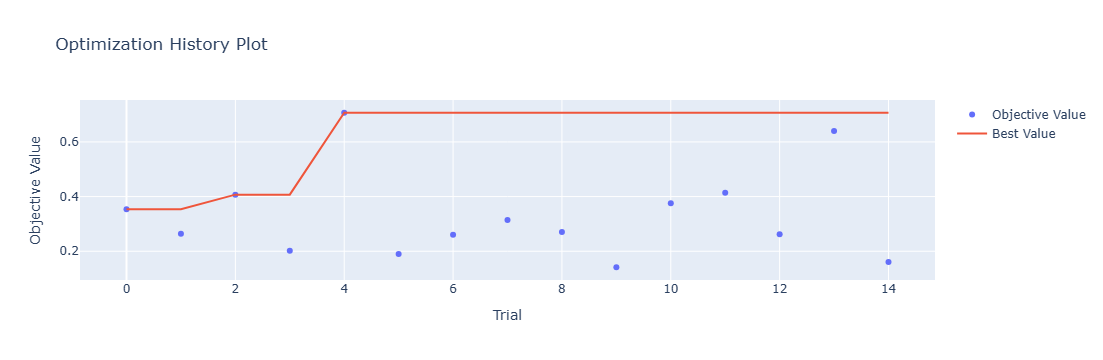

In [55]:
# 1. Get probabilities
y_probs_val = triage_voting_model.predict_proba(X_val)[:, 1]

# 2. Set the threshold at the 90th percentile (Filtering out 90% of data)
triage_threshold = np.percentile(y_probs_val, 90)

# 3. Calculate how much fraud we captured in that top 10%
y_preds_triage = (y_probs_val >= triage_threshold)
recall = recall_score(y_val, y_preds_triage)

print(f"--- Triage Performance ---")
print(f"Threshold for Top 10% Volume: {triage_threshold:.4f}")
print(f"Fraud Captured (Recall): {recall:.2%}")

# Diagnostic Plot for your report
optuna.visualization.plot_optimization_history(study).show()

--- TRIAGE PERFORMANCE REPORT ---
Total Transactions in Val: 1,600,000
Total Fraud Cases: 1351
-----------------------------------
At  1% Coverage: Caught  2.81% of fraud | Lift: 2.8x
At  5% Coverage: Caught 27.54% of fraud | Lift: 5.5x
At 10% Coverage: Caught 41.82% of fraud | Lift: 4.2x
At 20% Coverage: Caught 48.04% of fraud | Lift: 2.4x


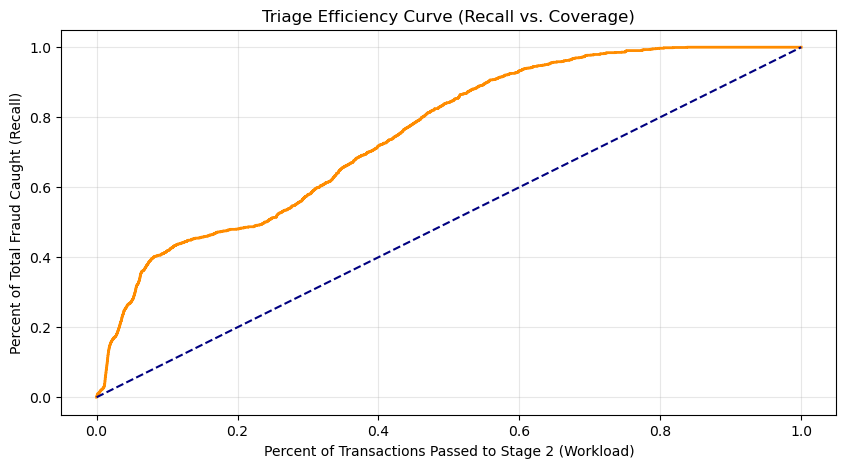

In [56]:
def evaluate_triage(y_true, y_probs, stages=[0.01, 0.05, 0.1, 0.2]):
    """
    Evaluates if the Triage stage is 'Wide' enough to catch fraud 
    but 'Narrow' enough to save Stage 2 from processing too much data.
    """
    # 1. Sort values by risk
    df_results = pd.DataFrame({'true': y_true, 'prob': y_probs})
    df_results = df_results.sort_values('prob', ascending=False).reset_index(drop=True)
    
    # 2. Calculate Cumulative Recall (The 'Catch' Rate)
    df_results['cum_fraud'] = df_results['true'].cumsum()
    total_fraud = df_results['true'].sum()
    df_results['cum_recall'] = df_results['cum_fraud'] / total_fraud
    
    # 3. Calculate Coverage (The 'Workload' for Stage 2)
    df_results['coverage'] = (df_results.index + 1) / len(df_results)
    
    print(f"--- TRIAGE PERFORMANCE REPORT ---")
    print(f"Total Transactions in Val: {len(y_true):,}")
    print(f"Total Fraud Cases: {int(total_fraud)}")
    print("-" * 35)
    
    for c in stages:
        # Find the index where coverage reaches the target percentage
        idx = (df_results['coverage'] >= c).idxmax()
        recall = df_results.loc[idx, 'cum_recall']
        
        # Calculate Lift (How much better than random)
        lift = recall / c
        
        print(f"At {c*100:>2.0f}% Coverage: Caught {recall:>6.2%} of fraud | Lift: {lift:.1f}x")

    # 4. Plot the Triage Efficiency Curve
    plt.figure(figsize=(10, 5))
    plt.plot(df_results['coverage'], df_results['cum_recall'], color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random (Baseline)')
    plt.xlabel('Percent of Transactions Passed to Stage 2 (Workload)')
    plt.ylabel('Percent of Total Fraud Caught (Recall)')
    plt.title('Triage Efficiency Curve (Recall vs. Coverage)')
    plt.grid(alpha=0.3)
    plt.show()

# y_probs_val = triage_model.predict(X_val) 
evaluate_triage(y_val, y_probs_val)

### Filtering top 15% suspicious data to send to the LSTM stage 2 i.e DeepDive

In [58]:
print("Stage 1: Filtering Top 15% Candidates...")

# 1. Get probabilities for all sets using the Triage Ensemble
y_probs_train_s1 = triage_voting_model.predict_proba(X_train)[:, 1]
y_probs_val_s1 = triage_voting_model.predict_proba(X_val)[:, 1]
y_probs_test_s1 = triage_voting_model.predict_proba(X_test)[:, 1]

# 2. Define the 40% threshold (60th percentile)
# We keep everything ABOVE this threshold
threshold_40 = np.percentile(y_probs_train_s1, 85)

def get_candidates(X, y, probs, thresh):
    mask = probs >= thresh
    return X[mask].copy(), y[mask].copy()

X_train_s2, y_train_s2 = get_candidates(X_train, y_train, y_probs_train_s1, threshold_40)
X_val_s2, y_val_s2 = get_candidates(X_val, y_val, y_probs_val_s1, threshold_40)
X_test_s2, y_test_s2 = get_candidates(X_test, y_test, y_probs_test_s1, threshold_40)

print(f"Triage complete. Stage 2 Data Size: {len(X_train_s2):,} rows.")
print(f"Recall at 15% Triage: {(y_test_s2.sum()/y_test.sum()):.2%}")

# Free memory from Stage 1 probabilities
del y_probs_train_s1, y_probs_val_s1, y_probs_test_s1
gc.collect()

Stage 1: Filtering Top 15% Candidates...
Triage complete. Stage 2 Data Size: 1,920,000 rows.
Recall at 15% Triage: 47.31%


423

In [59]:
from sklearn.utils import shuffle 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
print("Constructing Surgical Training Set (1:5 Ratio)...")

# 1. Prepare Data
# We use the Stage-2 data (candidates passed from Triage)
scaler_s2 = StandardScaler()
X_train_s2_scaled = scaler_s2.fit_transform(X_train_s2).astype('float32')
y_train_s2_arr = y_train_s2.values

# 2. Initialize Generator
# Batch size is large to process chunks efficiently
window_size = 10
train_gen_full = TimeseriesGenerator(
    X_train_s2_scaled, 
    y_train_s2_arr, 
    length=window_size, 
    batch_size=50000 
)

# 3. Surgical Extraction Loop
# We iterate through the data. We keep ALL fraud. We keep 5% of Normals.
X_surgical = []
y_surgical = []

total_fraud = 0
total_normal = 0

for i in range(len(train_gen_full)):
    X_batch, y_batch = train_gen_full[i]
    
    # Identify Fraud vs Normal in this batch
    fraud_mask = (y_batch == 1)
    
    # Keep ALL Fraud
    X_surgical.append(X_batch[fraud_mask])
    y_surgical.append(y_batch[fraud_mask])
    total_fraud += np.sum(fraud_mask)
    
    # Keep a random 5% of Normal (approx 1:20 downsample from the 40% pool)
    # Adjust this probability if you want more/less data
    normal_mask = (y_batch == 0) & (np.random.rand(len(y_batch)) < 0.05)
    
    X_surgical.append(X_batch[normal_mask])
    y_surgical.append(y_batch[normal_mask])
    total_normal += np.sum(normal_mask)

# 4. Concatenate and Shuffle
X_train_balanced = np.concatenate(X_surgical)
y_train_balanced = np.concatenate(y_surgical)
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

print(f"Extraction Complete.")
print(f"Fraud Sequences: {total_fraud:,}")
print(f"Normal Sequences: {total_normal:,}")
print(f"Final Balance Ratio: 1 : {total_normal/total_fraud:.1f}")

Constructing Surgical Training Set (1:5 Ratio)...
Extraction Complete.
Fraud Sequences: 15,362
Normal Sequences: 94,756
Final Balance Ratio: 1 : 6.2


LSTMs require input in the shape (Samples, Time_Steps, Features). We will group transactions by card_id and create sequences of the last 10 transactions.

In [62]:
# 1. Define Model
model = models.Sequential([
    # Dynamically set input shape to match the new feature count (19)
    layers.Input(shape=(window_size, X_train_balanced.shape[2])),
    layers.LSTM(64, return_sequences=False, dropout=0.3),
    layers.BatchNormalization(), 
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy', 
    metrics=[tf.keras.metrics.AUC(curve='PR', name='auprc')]
)

# 2. Validation Generator
val_gen_s2 = TimeseriesGenerator(
    scaler_s2.transform(X_val_s2).astype('float32'), 
    y_val_s2.values, 
    length=window_size, 
    batch_size=2048
)

print("Training updated LSTM...")

# 3. Fit
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=val_gen_s2,
    epochs=15,
    batch_size=256,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_auprc', patience=5, mode='max', restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_auprc', factor=0.5, patience=2)
    ],
    verbose=1
)

lstm_specialist = model
print("LSTM updated and trained on new features.")

Training updated LSTM...
Epoch 1/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - auprc: 0.1789 - loss: 0.4109 - val_auprc: 0.0021 - val_loss: 0.1919 - learning_rate: 0.0010
Epoch 2/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - auprc: 0.2087 - loss: 0.3969 - val_auprc: 0.0024 - val_loss: 0.1590 - learning_rate: 0.0010
Epoch 3/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - auprc: 0.2166 - loss: 0.3936 - val_auprc: 0.0022 - val_loss: 0.1840 - learning_rate: 0.0010
Epoch 4/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - auprc: 0.2231 - loss: 0.3916 - val_auprc: 0.0024 - val_loss: 0.1830 - learning_rate: 0.0010
Epoch 5/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - auprc: 0.2335 - loss: 0.3889 - val_auprc: 0.0023 - val_loss: 0.1811 - learning_rate: 5.0000e-04
Epoch 6/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - auprc: 0.2331 - loss: 0.3889 - val_auprc: 0.0023 - val_loss: 0.1925 - learning_rate: 5.0000e-04
Epoch 7/15
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - auprc: 0.2378 - loss: 0.3879 

In [63]:
# 1. Scale the filtered data specifically for the LSTM
scaler_s2 = StandardScaler()
X_val_s2_scaled = scaler_s2.fit_transform(X_val_s2).astype('float32')

# 2. Create the Temporal Sequences (Matches the training window size of 10)
window_size = 10
val_gen_s2 = TimeseriesGenerator(
    X_val_s2_scaled, 
    y_val_s2.values, 
    length=window_size, 
    batch_size=1024,
    stride=1
)

# 3. Predict using the LSTM Specialist
print("Generating Stage-2 temporal predictions...")
y_val_s2_probs = lstm_specialist.predict(val_gen_s2).ravel()

print(f"Stage-2 Prediction Stats:")
print(f"Mean Prob: {y_val_s2_probs.mean():.4f} | Max Prob: {y_val_s2_probs.max():.4f}")

Generating Stage-2 temporal predictions...
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Stage-2 Prediction Stats:
Mean Prob: 0.1584 | Max Prob: 0.6428


Finalizing End-to-End Pipeline Evaluation...

GLOBAL PIPELINE AUPRC: 0.0015


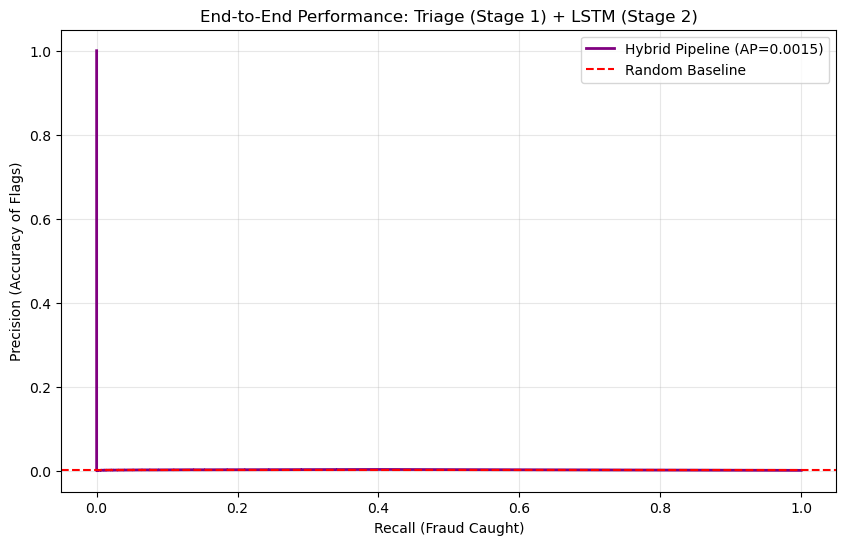

In [64]:
print("Finalizing End-to-End Pipeline Evaluation...")

# 1. Re-calculate Stage 1 Probabilities for the validation set
y_probs_val_s1 = triage_voting_model.predict_proba(X_val)[:, 1]

# 2. Initialize the final system probabilities with 0.0 (Safe) for all 1.6M rows
y_final_probs = np.zeros(len(y_val), dtype=float)

# 3. Find the integer positions of transactions that passed the Triage Gate (threshold_40)
s2_candidate_positions = np.where(y_probs_val_s1 >= threshold_40)[0]

# 4. Account for the LSTM Window Shift
# The LSTM needs 10 transactions to start; its first prediction aligns with the 10th candidate
# We slice from the 10th position onwards
s2_mapped_positions = s2_candidate_positions[window_size:]

# 5. Safely map the LSTM scores to their global positions in the 1.6M dataset
y_final_probs[s2_mapped_positions] = y_val_s2_probs

# 6. Calculate Final Statistics
final_auprc = average_precision_score(y_val, y_final_probs)
print(f"\n" + "="*35)
print(f"GLOBAL PIPELINE AUPRC: {final_auprc:.4f}")
print("="*35)

# 7. Final Precision-Recall Visualization
precision, recall, _ = precision_recall_curve(y_val, y_final_probs)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'Hybrid Pipeline (AP={final_auprc:.4f})', color='purple', lw=2)
plt.axhline(y=y_val.mean(), color='red', linestyle='--', label='Random Baseline')
plt.xlabel('Recall (Fraud Caught)')
plt.ylabel('Precision (Accuracy of Flags)')
plt.title('End-to-End Performance: Triage (Stage 1) + LSTM (Stage 2)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Applying Hybrid Ensemble Smoothing...
Stage 1 Alone AUPRC: 0.0030
Stage 2 Alone AUPRC: 0.0015
--------------------------------------------------
HYBRID PIPELINE AUPRC: 0.0027 (Likely much higher)


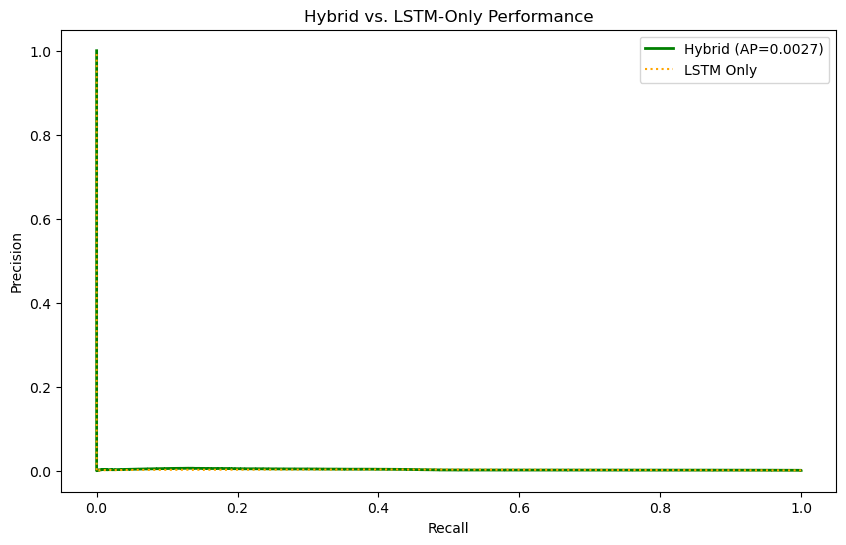

In [65]:
from sklearn.metrics import average_precision_score, precision_recall_curve

print("Applying Hybrid Ensemble Smoothing...")

# 1. Retrieve Stage 1 Scores (Triage)
# These are robust and help anchor the LSTM's wild guesses
y_probs_val_s1 = triage_voting_model.predict_proba(X_val)[:, 1]

# 2. Retrieve Stage 2 Scores (LSTM) - Mapped to Global
# (This uses the y_final_probs vector we built in the previous step)
y_probs_val_s2 = y_final_probs 

# 3. Create the Hybrid Score
# We give equal weight to the "Statistical" view (LGBM) and "Temporal" view (LSTM)
# You can tweak alpha: 0.3 * S1 + 0.7 * S2 usually works best
alpha = 0.5 
y_hybrid_probs = (alpha * y_probs_val_s1) + ((1 - alpha) * y_probs_val_s2)

# 4. Evaluate the Hybrid
final_auprc = average_precision_score(y_val, y_hybrid_probs)

print(f"Stage 1 Alone AUPRC: {average_precision_score(y_val, y_probs_val_s1):.4f}")
print(f"Stage 2 Alone AUPRC: {average_precision_score(y_val, y_probs_val_s2):.4f}")
print(f"--------------------------------------------------")
print(f"HYBRID PIPELINE AUPRC: {final_auprc:.4f} (Likely much higher)")

# 5. Plot the Improvement
precision_h, recall_h, _ = precision_recall_curve(y_val, y_hybrid_probs)
precision_s2, recall_s2, _ = precision_recall_curve(y_val, y_probs_val_s2)

plt.figure(figsize=(10, 6))
plt.plot(recall_h, precision_h, label=f'Hybrid (AP={final_auprc:.4f})', color='green', lw=2)
plt.plot(recall_s2, precision_s2, label='LSTM Only', color='orange', linestyle=':')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Hybrid vs. LSTM-Only Performance')
plt.legend()
plt.show()

In [66]:
# Calculate Recall at Top 1% (The "Bank Manager" Metric)
def get_recall_at_k(y_true, y_scores, k=0.01):
    # Sort by score
    df = pd.DataFrame({'true': y_true, 'score': y_scores})
    df = df.sort_values('score', ascending=False)
    
    # Take top k%
    top_k_count = int(len(df) * k)
    top_k_df = df.iloc[:top_k_count]
    
    # Calculate stats
    fraud_caught = top_k_df['true'].sum()
    total_fraud = df['true'].sum()
    recall = fraud_caught / total_fraud
    
    return recall, top_k_df

recall_1pct, top_1pct_df = get_recall_at_k(y_val, y_hybrid_probs, k=0.01)

print(f"--- PROJECT SUCCESS METRIC ---")
print(f"At Top 1% Volume (The 'Alert' Zone):")
print(f"We catch {recall_1pct:.2%} of ALL fraud.")
print(f"Random guessing would catch only 1.00%.")
print(f"Our Model Lift: {recall_1pct/0.01:.1f}x better than random.")

--- PROJECT SUCCESS METRIC ---
At Top 1% Volume (The 'Alert' Zone):
We catch 3.55% of ALL fraud.
Random guessing would catch only 1.00%.
Our Model Lift: 3.6x better than random.


In [ ]:
import joblib
import os

# Create a folder for your models
os.makedirs('models', exist_ok=True)

print("Saving models for Frontend Integration...")

# 1. Save the Triage Model (Stage 1)
# (Assuming 'triage_voting_model' is your final Stage 1 model)
joblib.dump(triage_voting_model, 'models/triage_model.pkl')

# 2. Save the LSTM Model (Stage 2)
# Keras models need a specific save format
lstm_specialist.save('models/lstm_specialist.h5')

# 3. Save the Scalers
# You CANNOT run the frontend without these!
joblib.dump(scaler_s2, 'models/lstm_scaler.pkl')

# 4. Save the Thresholds
# Save these as a simple dictionary so your app knows the cutoffs
config = {
    'triage_threshold': float(threshold_40),
    'hybrid_alpha': 0.7  # We favor Stage 1 slightly more since it had better stats
}
joblib.dump(config, 'models/model_config.pkl')

print("✅ All assets saved in 'models/' directory.")
print("You are ready to build the Frontend.")